In [1]:
import pandas as pd

%load_ext autoreload
%autoreload 2

ds = pd.read_csv('./../data/train.csv', index_col='id')
ds_test = pd.read_csv('./../data/test.csv', index_col='id')
ds

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,/j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg,...,4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",1596687
2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,/sS01LSy6KDrCZAhtkO18UdnWFT1.jpg,...,3/28/13,102.0,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,NaN,We Are the Best!,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",180590
2998,NaN,65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,/4MENR8x6mYqnZvp2hGjSaPJz64J.jpg,...,10/11/96,120.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What's forgotten is not always gone.,Th

In [24]:
import kowalsky
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

def train_test_feed(train, test, make_feed, params):
    return make_feed(train, params), make_feed(test, params | { 'is_test': True })

def eval_feed(make_feed, id, **params):
    train, test = train_test_feed(ds, ds_test, make_feed, params)
    train.to_csv(f"./../data/feed/feed_{id}.csv")
    test.to_csv(f"./../data/feed/feed_{id}_test.csv")

    model = DecisionTreeRegressor(max_depth=4)
    kowalsky.analysis(model,
                      y_column='revenue',
                      path=f"./../data/feed/feed_{id}.csv",
                      path_test=f"./../data/feed/feed_{id}_test.csv",
                      path_out=f"./../data/out/dt_{id}.csv",
                      sample_path='./../data/sample_submission.csv',
                      scorer='rmsle',
                      greater_is_better=False,
                      export_test_set=True,
                      target_transform_fn=params.get('target_transform_fn'),
                      rounds=10)
    # print(sorted(list(zip(model.feature_importances_, train.columns)), reverse=True))

In [25]:
from kowalsky.df import drop

def make_feed_1(ds_raw, params={}):
    ds = ds_raw.copy()
    
    ds = drop(ds, ['belongs_to_collection', 'genres', 'homepage',
              'imdb_id', 'original_title', 'overview', 'poster_path',
              'production_companies', 'production_countries',
              'spoken_languages', 'status', 'tagline', 'title',
              'Keywords', 'cast', 'crew', 'original_language'])
    ds.release_date = ds.release_date.fillna('1/1/0')
    ds.runtime = ds.runtime.fillna(ds.runtime.mean())

    ds['month'] = ds.release_date.apply(
        lambda str: int(str.split('/')[0])
    )
    ds['day'] = ds.release_date.apply(
        lambda str: int(str.split('/')[1])
    )

    def parse_year(str):
        num = int(str.split('/')[2])
        return num + 2000 if num < 19 else num + 1900
    ds['year'] = ds.release_date.apply(parse_year)
    ds = drop(ds, ['release_date'])

    return ds

eval_feed(make_feed_1, '1')
make_feed_1(ds)

2.896221292900516


,budget,popularity,runtime,revenue,month,day,year
id,,,,,,,
1,14000000,6.575393,93.0,12314651,2,20,2015
2,40000000,8.248895,113.0,95149435,8,6,2004
3,3300000,64.299990,105.0,13092000,10,10,2014
4,1200000,3.174936,122.0,16000000,3,9,2012
5,0,1.148070,118.0,3923970,2,5,2009
...,...,...,...,...,...,...,...
2996,0,9.853270,102.0,1596687,4,22,1994
2997,0,3.727996,102.0,180590,3,28,2013
2998,65000000,14.482345,120.0,89456761,10,11,1996


0.2189941845206281


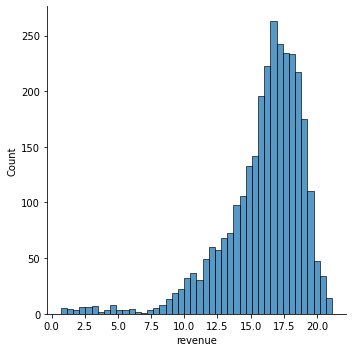

In [26]:
from kowalsky.df import transform
import seaborn as sns
import numpy as np

def make_feed_2(ds_raw, params={}):
    ds = make_feed_1(ds_raw, params)

    ds = transform(ds, ['revenue'])

    return ds

feed_2 = make_feed_2(ds)
sns.displot(feed_2.revenue)
eval_feed(make_feed_2, '2', target_transform_fn=np.expm1)

0.2189941845206281


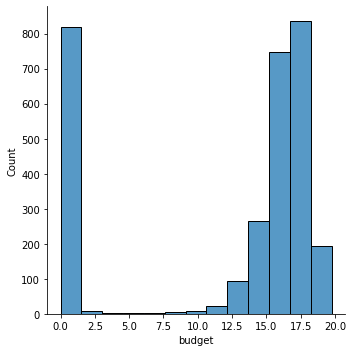

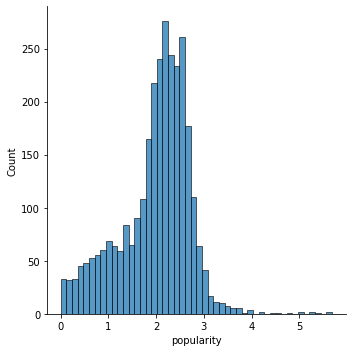

In [27]:
def make_feed_3(ds_raw, params={}):
    ds = make_feed_2(ds_raw)

    ds = transform(ds, ['budget', 'popularity'])

    return ds

feed_3 = make_feed_3(ds)
sns.displot(feed_3.budget)
sns.displot(feed_3.popularity)
eval_feed(make_feed_3, '3', target_transform_fn=np.expm1)

In [43]:
from kowalsky.df import handle_outliers

def make_feed_4(ds_raw, params={}):
    ds = make_feed_2(ds_raw)

    if not params.get('is_test', False):
        ds = handle_outliers(ds, ['popularity'], drop=True)

    return ds

eval_feed(make_feed_4, '4', target_transform_fn=np.expm1)

0.2046807260599118


In [52]:
from kowalsky.df import scale

def make_feed_5(ds_raw, params={}):
    ds = make_feed_4(ds_raw, params)

    ds = scale(ds, ['budget'])

    return ds

eval_feed(make_feed_5, '5', target_transform_fn=np.expm1)
make_feed_5(ds)

0.20359518294098095


,budget,popularity,runtime,revenue,month,day,year
id,,,,,,,
1,-0.204864,6.575393,93.0,16.326300,2,20,2015
2,0.634807,8.248895,113.0,18.370959,8,6,2004
4,-0.618240,3.174936,122.0,16.588099,3,9,2012
5,-0.656994,1.148070,118.0,15.182615,2,5,2009
6,-0.398634,0.743274,83.0,14.997740,8,6,1987
...,...,...,...,...,...,...,...
2996,-0.656994,9.853270,102.0,14.283442,4,22,1994
2997,-0.656994,3.727996,102.0,12.103990,3,28,2013
2998,1.442183,14.482345,120.0,18.309266,10,11,1996


In [59]:
from xgboost import XGBRegressor

id = 4
kowalsky.analysis(XGBRegressor(**{'learning_rate': 0.21459742731195008, 'n_estimators': 73, 'max_depth': 5, 'gamma': 0.7088309669558474}),
                      y_column='revenue',
                      path=f"./../data/feed/feed_{id}.csv",
                      path_test=f"./../data/feed/feed_{id}_test.csv",
                      path_out=f"./../data/out/!xgb_{id}.csv",
                      sample_path='./../data/sample_submission.csv',
                      scorer='rmsle',
                      greater_is_better=False,
                      export_test_set=True,
                      target_transform_fn=np.expm1)

0.21801364546991323


In [60]:
from lightgbm import LGBMRegressor

id = 4
kowalsky.analysis(LGBMRegressor(**{'learning_rate': 0.2690147408246944, 'n_estimators': 800, 'max_depth': 3, 'num_leaves': 185, 'min_child_samples': 155}),
                      y_column='revenue',
                      path=f"./../data/feed/feed_{id}.csv",
                      path_test=f"./../data/feed/feed_{id}_test.csv",
                      path_out=f"./../data/out/!lgb_{id}.csv",
                      sample_path='./../data/sample_submission.csv',
                      scorer='rmsle',
                      greater_is_better=False,
                      export_test_set=True,
                      target_transform_fn=np.expm1)

0.19631165274163376


In [61]:
from sklearn.ensemble import RandomForestRegressor

id = 4
kowalsky.analysis(RandomForestRegressor(**{'min_samples_leaf': 3, 'min_samples_split': 0.05209842300647795, 'n_estimators': 108, 'max_depth': 9}),
                      y_column='revenue',
                      path=f"./../data/feed/feed_{id}.csv",
                      path_test=f"./../data/feed/feed_{id}_test.csv",
                      path_out=f"./../data/out/!rf_{id}.csv",
                      sample_path='./../data/sample_submission.csv',
                      scorer='rmsle',
                      greater_is_better=False,
                      export_test_set=True,
                      target_transform_fn=np.expm1)

0.19909202363189843
